## **Goal**
A/B Testing is a controlled experiment comparing two or more variants to determine which version performs better based on a predefined metric. This project analyzes game user data to evaluate feature performance, aiming to:
* Increase user retention
* Boost in-game purchases
* Improve overall user experience

## **Data Description**
* userid - a unique number that identifies each player.
* version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
* sum_gamerounds - the number of game rounds played by the player during the first week after installation
* retention_1 - did the player come back and play 1 day after installing?
* retention_7 - did the player come back and play 7 days after installing?

## **Import**

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import shapiro
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
path = "../input/mobile-games-ab-testing/cookie_cats.csv"
ab = pd.read_csv(path)
ab

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


## **EDA**

In [3]:
# A/B Groups & Target Summary Stats
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


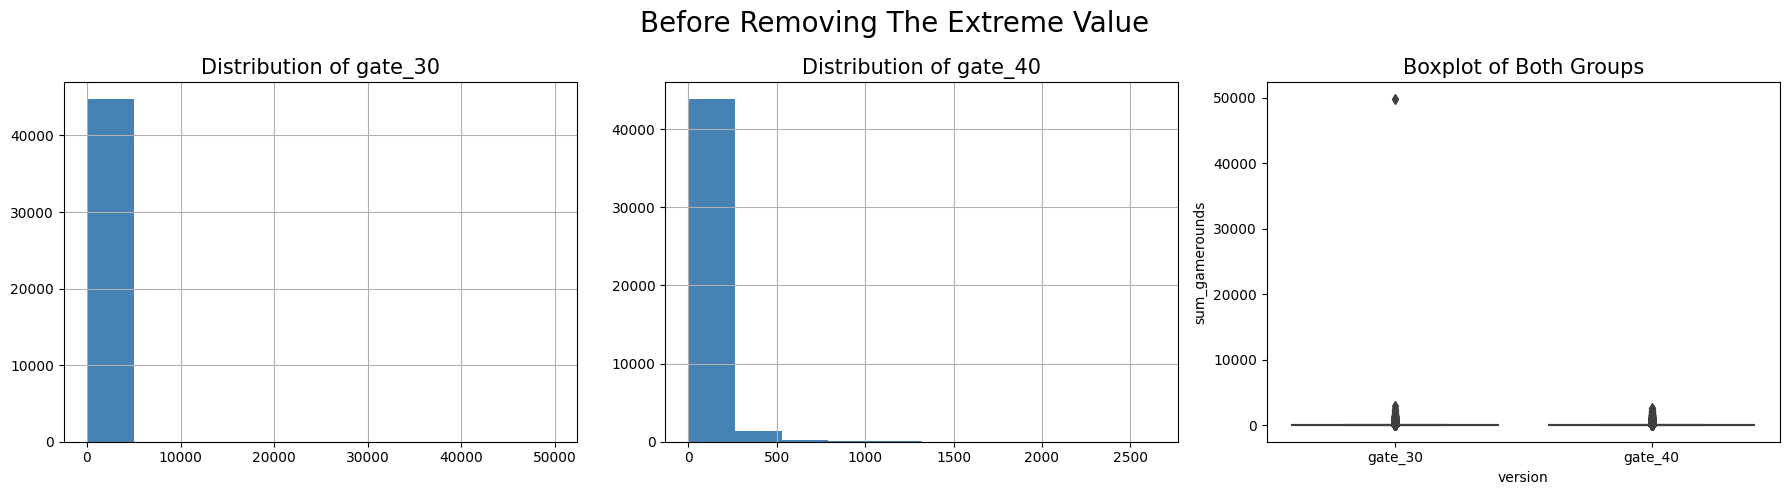

In [4]:
# Define versions and create subplots
versions = ["gate_30", "gate_40"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot histograms
for i, v in enumerate(versions):
    ab[ab["version"] == v].hist("sum_gamerounds", ax=axes[i], color="steelblue")
    axes[i].set_title(f"Distribution of {v}", fontsize=15)

# Plot boxplot
sns.boxplot(x="version", y="sum_gamerounds", data=ab, ax=axes[2])
axes[2].set_title("Boxplot of Both Groups", fontsize=15)

# Final layout
plt.suptitle("Before Removing The Extreme Value", fontsize=20)
plt.tight_layout()

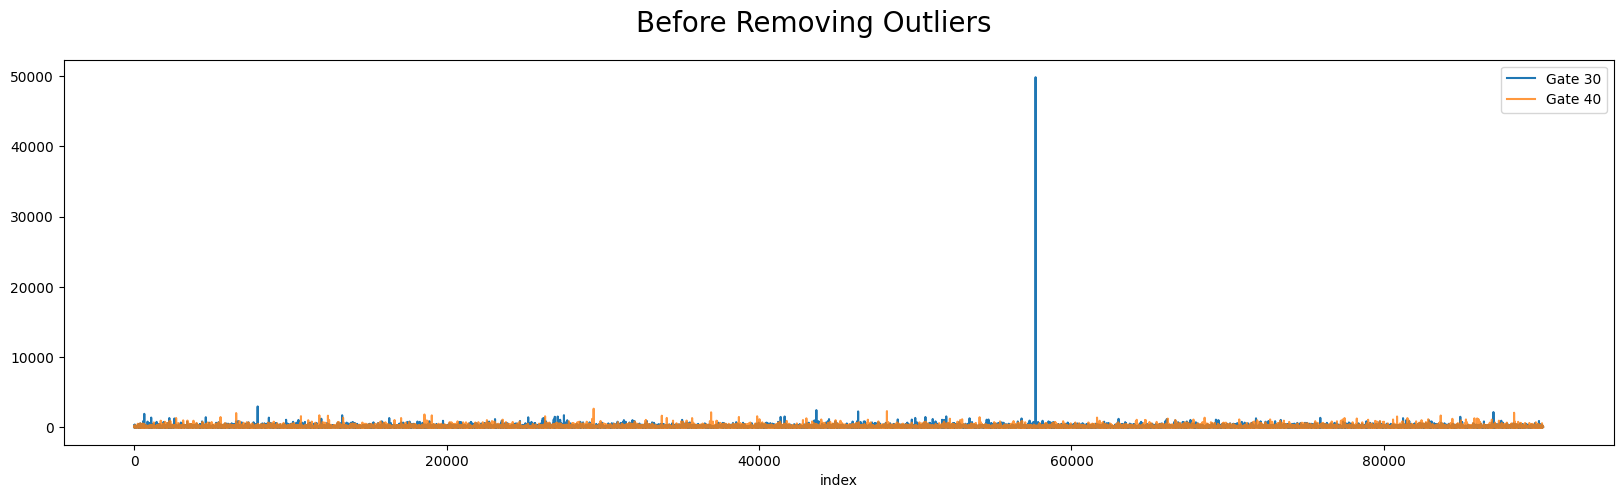

In [5]:
ab[(ab.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
ab[ab.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("Before Removing Outliers", fontsize = 20);

In [6]:
lower_bound = ab["sum_gamerounds"].quantile(0.00)
upper_bound = ab["sum_gamerounds"].quantile(0.99)
l = len(ab)
ab = ab[(ab["sum_gamerounds"] >= lower_bound) & (ab["sum_gamerounds"] <= upper_bound)]

num_outliers = l - len(ab)
print(f"Number of outliers removed: {num_outliers}")

Number of outliers removed: 898


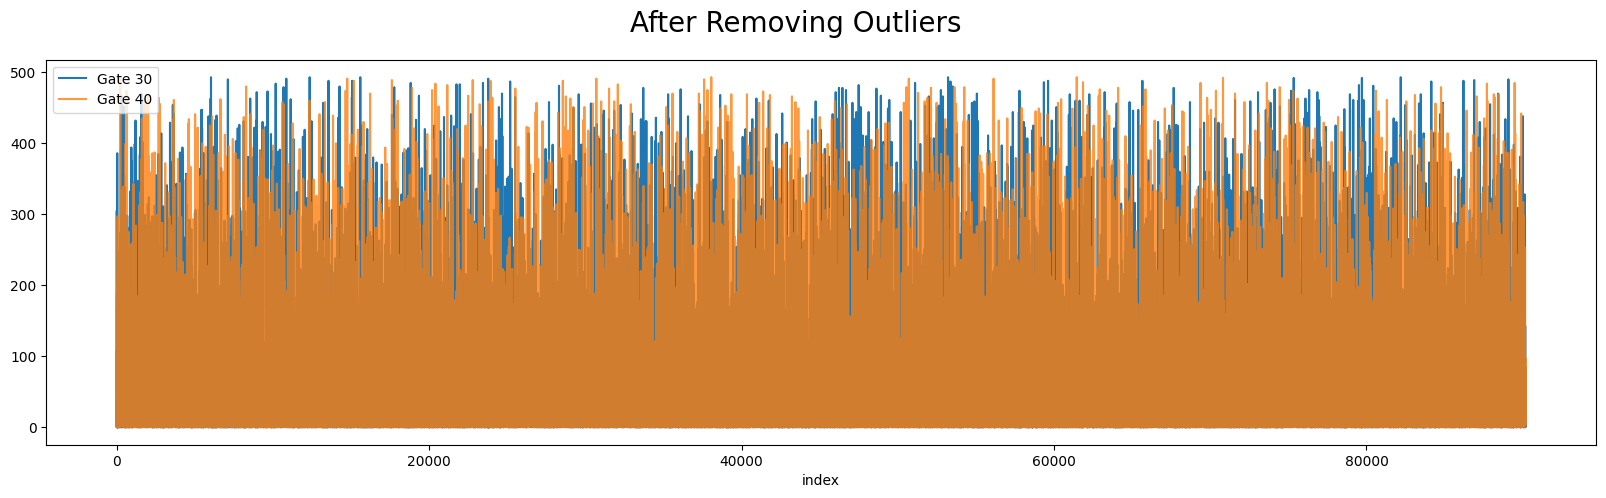

In [7]:
ab[(ab.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
ab[ab.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("After Removing Outliers", fontsize = 20);

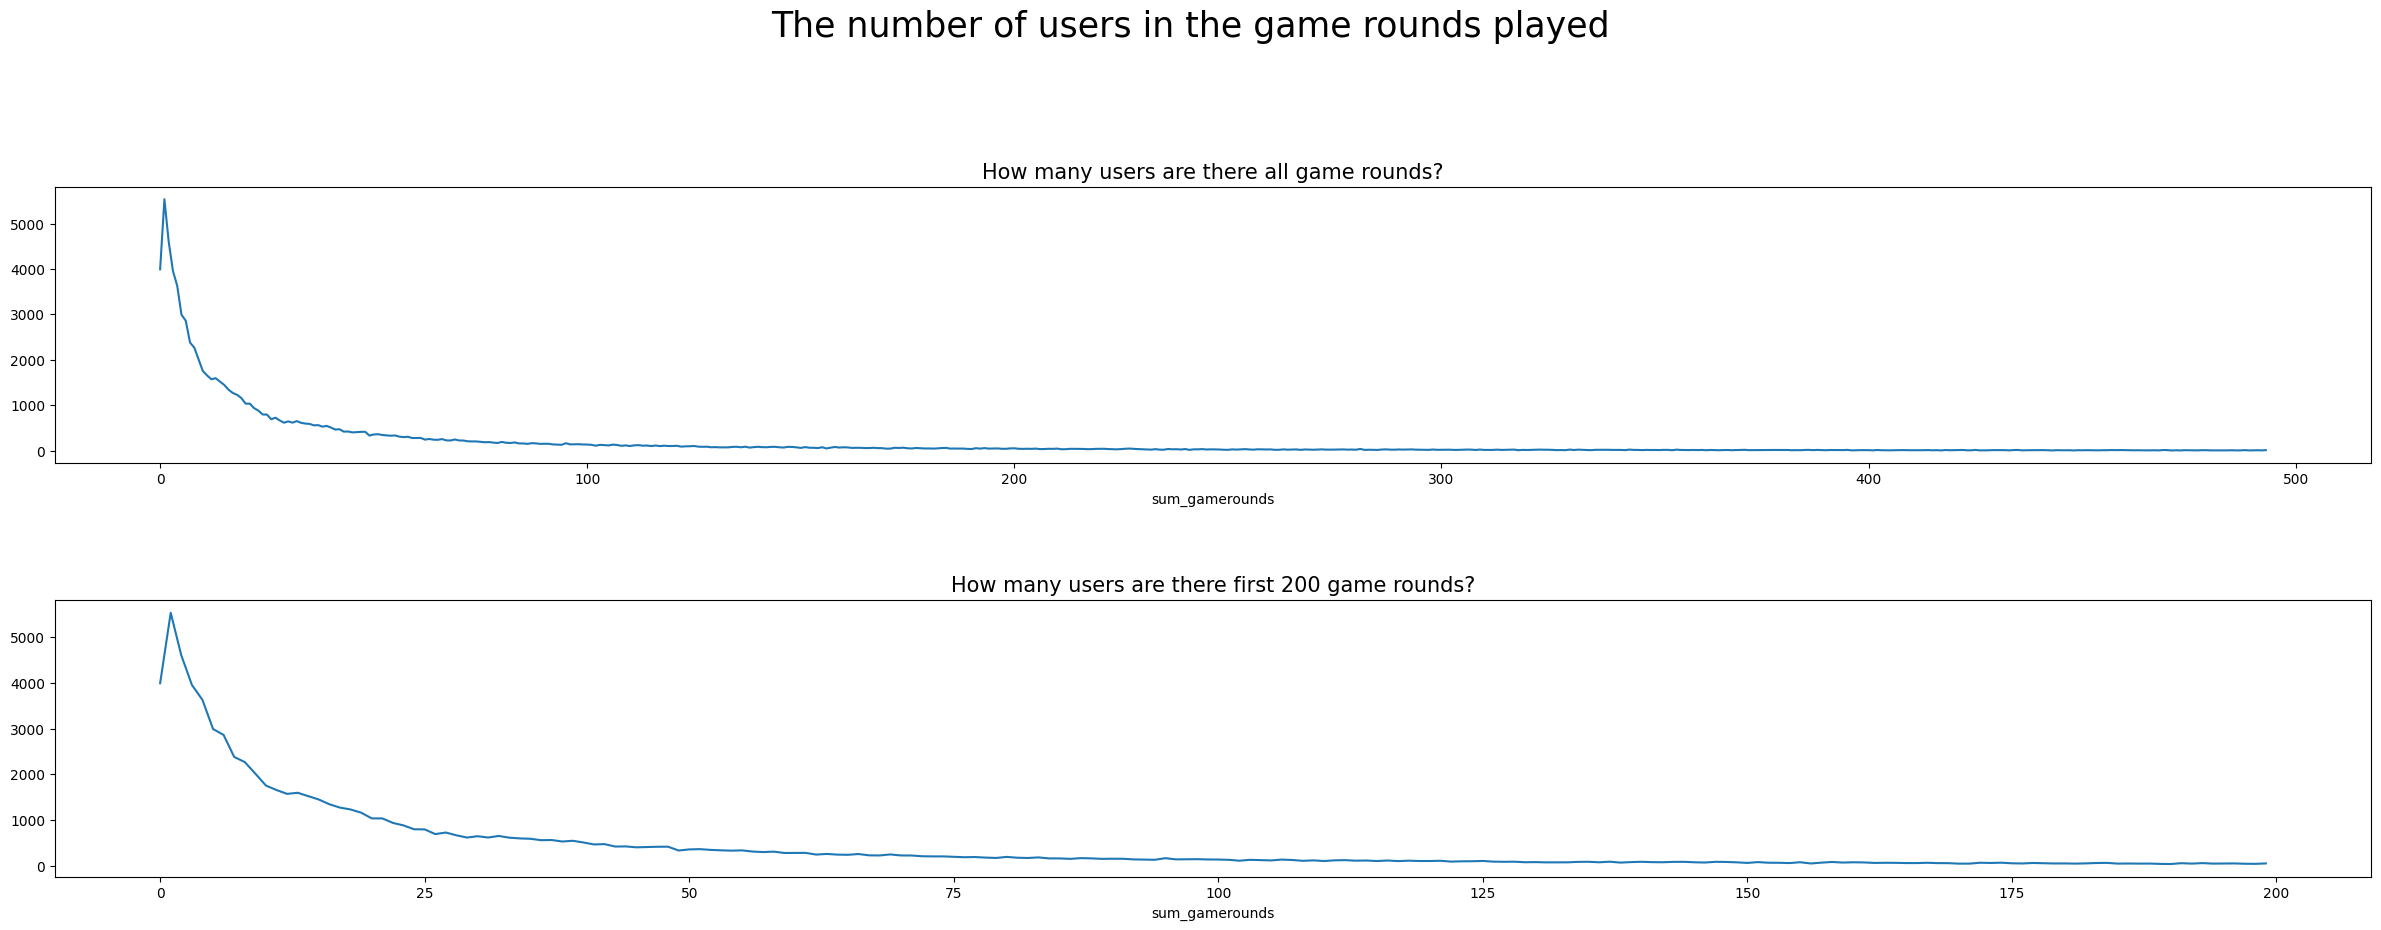

In [8]:
fig, axes = plt.subplots(2, 1, figsize = (25,10))
ab.groupby("sum_gamerounds").userid.count().plot(ax = axes[0])
ab.groupby("sum_gamerounds").userid.count()[:200].plot(ax = axes[1])
plt.suptitle("The number of users in the game rounds played", fontsize = 25)
axes[0].set_title("How many users are there all game rounds?", fontsize = 15)
axes[1].set_title("How many users are there first 200 game rounds?", fontsize = 15)
plt.tight_layout(pad=5);

In [9]:
ab.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median       mean        std  max
version retention_1                                          
gate_30 False        24653     6.0  15.992374  32.285092  483
        True         19601    46.0  80.722106  89.991483  493
gate_40 False        25360     6.0  16.047121  32.370967  489
        True         19677    48.0  80.933323  89.403137  493

In [10]:
ab.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median        mean         std  max
version retention_7                                            
gate_30 False        36176    11.0   25.418537   40.388335  490
        True          8078    97.5  130.843402  110.023694  493
gate_40 False        37192    11.0   25.518472   40.269747  491
        True          7845   104.0  133.893818  109.521812  493

In [11]:
ab["NewRetention"] = list(map(lambda x,y: str(x)+"-"+str(y), ab.retention_1, ab.retention_7))
ab.groupby(["version", "NewRetention"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

,version,NewRetention,count,median,mean,std,max
0,gate_30,False-False,22838,6.0,11.741527,19.951605,455
1,gate_30,False-True,1815,43.0,69.480441,77.869442,483
2,gate_30,True-False,13338,33.0,48.837007,53.610493,490
3,gate_30,True-True,6263,118.0,148.626217,111.577909,493
4,gate_40,False-False,23596,6.0,11.890617,20.609123,463
5,gate_40,False-True,1764,46.0,71.646259,77.871883,489
6,gate_40,True-False,13596,32.0,49.169756,53.078559,491
7,gate_40,True-True,6081,123.0,151.950830,110.754210,493


## **A/B Testing**

In [12]:
# Define A/B groups
ab["version"] = np.where(ab.version == "gate_30", "A", "B")
ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7,NewRetention
0,116,A,3,False,False,False-False
1,337,A,38,True,False,True-False
2,377,B,165,True,False,True-False
3,483,B,1,False,False,False-False
4,488,B,179,True,True,True-True


In [13]:
# A/B Testing Function
def AB_Test(dataframe, group, target):

    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal
    # H1: Distribution is not Normal
    
    if (ntA == False) & (ntB == False): # H0: Normal Distribution
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity
        # H1: Heterogeneous
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2
            # H1: M1 != M2
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2
            # H1: M1 != M2
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2
        # H1: M1 != M2
        
    # Result
    result = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    result["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    result["AB Hypothesis"] = np.where(result["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    result["Comment"] = np.where(result["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    if (ntA == False) & (ntB == False):
        result["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        result = result[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        result = result[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return result
    
    
    
# Apply A/B Testing
AB_Test(dataframe=ab, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.04789,A/B groups are not similar!
